In [1]:
import sys
MODULE_FULL_PATH = './src/'
sys.path.insert(1, MODULE_FULL_PATH)

import os
import tensorflow as tf
import yaml
from data_loader import load_data, preprocess 
from utils import ExpDecay, iterative_optimize
from model import SchedulingModel
from training import TrainingController
import matplotlib.pyplot as plt
import seaborn as sb
import json

In [2]:
print('TF version {}'.format(tf.__version__))

config_path = 'config.yaml'
with open(config_path, 'r') as stream:
    config_param = yaml.safe_load(stream)

TF version 2.3.1


In [3]:
x, y = load_data(config_param.get('x_path'), config_param.get('y_path'))
data_train, data_val, data_test, data_properties = preprocess(x, y, config_param.get('batch_size'), config_param.get('split'))

100%|██████████| 5000/5000 [00:03<00:00, 1367.75it/s]


In [4]:
lr = ExpDecay(initial_learning_rate=config_param.get('learning_rate'), k=0.0001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=config_param.get('beta_1'),
    beta_2=config_param.get('beta_2'),
    epsilon=1e-6
)

In [5]:
# Shape: (batch) x number of jobs x (pt + dd + st)
job_queue = tf.keras.layers.Input([9, 7], name='in_jobs')
machine_state = tf.keras.layers.Input([5], name='in_machine_state')
enc_padding_mask = tf.keras.layers.Input([1, 1, 9], name='in_enc_pad_mask')

output, [jq_emb, ms_emb], attn = SchedulingModel(
    hidden_size=config_param.get('hidden_size'),
    num_attention_heads=config_param.get('nb_attn_heads'),
    ffn_size=config_param.get('ffn_size'),
    dropout_rate=config_param.get('dropout_rate'),
    epsilon=config_param.get('epsilon'),
    num_machines=3,
)([job_queue, machine_state, enc_padding_mask])

model = tf.keras.models.Model(
    inputs=[job_queue, machine_state, enc_padding_mask],
    outputs=[output, [jq_emb, ms_emb], attn])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_jobs (InputLayer)            [(None, 9, 7)]       0                                            
__________________________________________________________________________________________________
in_machine_state (InputLayer)   [(None, 5)]          0                                            
__________________________________________________________________________________________________
in_enc_pad_mask (InputLayer)    [(None, 1, 1, 9)]    0                                            
__________________________________________________________________________________________________
scheduling_model (SchedulingMod ((None, 9), [(None,  26259841    in_jobs[0][0]                    
                                                                 in_machine_state[0][0]

In [6]:
model_path = os.path.join(config_param.get('model_path'), 'model' + config_param.get('model_format'))
model_config_path = os.path.join(config_param.get('model_path'), 'model_config.json')

model.save(model_path, overwrite=True) 

with open(model_config_path, 'w+') as f:
    json.dump(model.to_json(), f)

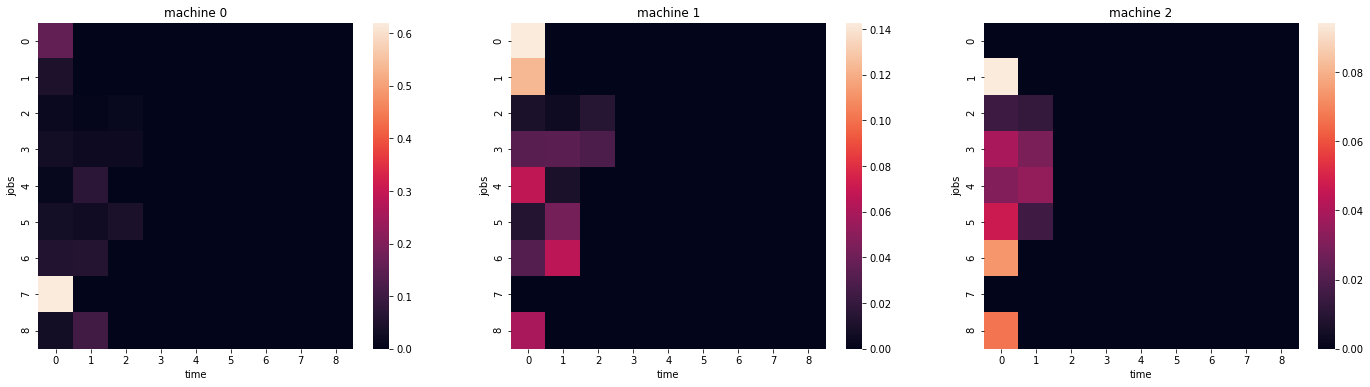

In [7]:
x_test_sample, y_test_sample = next(data_test)
total_loss, grads, schedule, m, [jq_emb, ms_emb], attn = iterative_optimize(optimizer=optimizer,
                                                                            model=model,
                                                                            x=x_test_sample,
                                                                            y_true=y_test_sample,
                                                                            data_properties=data_properties,
                                                                            training=False)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24, 6))

sb.heatmap(schedule[0,0], ax=ax1)
ax1.set_title("machine 0")
ax1.set_xlabel("time")
ax1.set_ylabel("jobs")

sb.heatmap(schedule[0,1], ax=ax2)
ax2.set_title("machine 1")
ax2.set_xlabel("time")
ax2.set_ylabel("jobs")

sb.heatmap(schedule[0,2], ax=ax3)
ax3.set_title("machine 2")
ax3.set_xlabel("time")
ax3.set_ylabel("jobs")

plt.show()

In [8]:
spe_train = data_properties.get('train_size') // config_param["batch_size"]
spe_val = data_properties.get('val_size') // config_param["batch_size"]
spe_test = data_properties.get('test_size') // config_param["batch_size"]
spe_train = 10
ckpt_path = os.path.join(config_param.get('checkpoint_path'), config_param.get("checkpoint_name"))

train_controller = TrainingController(
    model=model,
    optimizer=optimizer,
    log_file_dir=config_param.get('log_path'),
    data_properties=data_properties
)
train_controller.train(
    train_data=data_train,
    val_data=data_val,
    epochs=config_param.get("epochs"),
    validation_steps=spe_val,
    steps_per_epoch=spe_train,
    checkpoint_path=ckpt_path
)

[Train] [E 1/1] [B 10/10] Loss: 2.421931505203247 Acc: 0.13402777910232544 Pre: 0.2171623706817627 Rec: 0.0068865744397044183
[Valid] [E 0/0] [B 6/6] Loss: 2.220519781112671 Acc: 0.16898147761821747 Pre: 0.35227909684181213 Rec: 0.010031066834926605

